In [1]:
cd /home/watts/lal/Kaggle/lung_cancer

/home/watts/lal/medicine-ai/lung_cancer


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
import argparse
from time import strftime
from tqdm import tqdm
import sys

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi
from numpy.lib.format import open_memmap
import dicom
import scipy.misc
from utils.my_preprocessing import get_segmented_lungs, get_region_of_interest, remove_two_largest_connected
from utils.my_luna16_segment_lung_ROI import do_lungmask, do_final_processing, do_thresholding

In [3]:
#from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
try:
    from tqdm import tqdm # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x

In [4]:
luna_path = "/home/watts/lal/Kaggle/lung_cancer/data_luna16/"
luna_subset_path = luna_path+"subsetall_my/"
output_path = "/home/watts/lal/Kaggle/lung_cancer/cache/luna16/"
file_list=glob(luna_subset_path+"*.mhd")

In [5]:
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

In [6]:
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()

In [7]:
df_node.shape

(1186, 6)

In [8]:
df_node.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,/home/watts/lal/Kaggle/lung_cancer/data_luna16...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,/home/watts/lal/Kaggle/lung_cancer/data_luna16...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,/home/watts/lal/Kaggle/lung_cancer/data_luna16...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,/home/watts/lal/Kaggle/lung_cancer/data_luna16...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,/home/watts/lal/Kaggle/lung_cancer/data_luna16...


In [9]:
len(file_list)

888

In [27]:
k = 0
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    #print mini_df
    
    if mini_df.shape[0]>0 and k==0: # some files may not have a nodule--skipping those 
        k = 1
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        print img_array.shape 
        print num_z
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            print node_x
            print node_y
            print node_z
            # just keep 3 slices
            imgs = np.ndarray([7,height,width],dtype=np.float32)
            masks = np.ndarray([7,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            print center
            print v_center
            print int(v_center[2])-1
            print int(v_center[2])+6
            print num_z-1
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+6).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                print i
                print i_z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            print imgs.shape
            #np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            #np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)

  0%|          | 1/888 [00:00<03:16,  4.51it/s]

(177, 512, 512)
177
-57.0819205
-85.17233126
-214.5551686
[ -57.0819205   -85.17233126 -214.5551686 ]
[ 158.  331.   71.]
70
77
176
0
70
1
71
2
72
3
73
4
74
5
75
6
76
(7, 512, 512)
-48.22664898
-66.08106226
-209.0373634
[ -48.22664898  -66.08106226 -209.0373634 ]
[ 170.  356.   74.]
73
80
176
0
73
1
74
2
75
3
76
4
77
5
78
6
79
(7, 512, 512)


100%|██████████| 888/888 [00:00<00:00, 1015.04it/s]


In [13]:
myTrain = np.load(output_path+"myTrainImages.npy")


NameError: name 'nyTrain' is not defined

In [14]:
print myTrain.shape

(3553, 1, 512, 512)


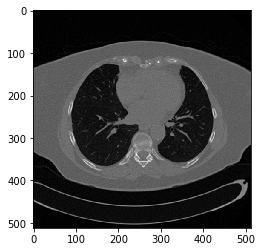

In [16]:
%matplotlib inline

plt.imshow(imgs[0], cmap='gray')

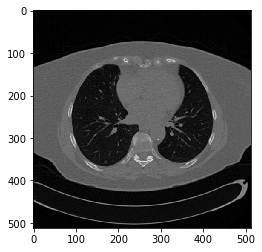

In [17]:
plt.imshow(imgs[1], cmap='gray')

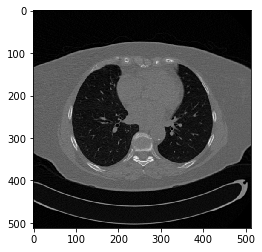

In [18]:
plt.imshow(imgs[2], cmap='gray')

In [60]:
my_img = np.load('cache/luna16/02242017_41_41_7/my_images_0678_0853.npy')

In [61]:
my_img.shape

(7, 41, 41)

In [62]:
working_path = "/home/watts/lal/Kaggle/lung_cancer/cache/luna16/02242017_41_41_7/"

In [63]:
file_list=glob(working_path+"my_images_*.npy")


In [81]:
out_images = [] 
num_images = 1186
final_images = np.ndarray([num_images,1,7,41,41],dtype=np.float32)
final_masks = np.ndarray([num_images,1,7,41,41],dtype=np.float32)
for i, img_file in enumerate(tqdm(file_list)):
    imgs = np.load(img_file)
    if (7, 41, 41) != imgs.shape:
        print i
        print imgs.shape
    #print final_images[i,0].shape
    final_images[i,0] = imgs
    
my_fname = working_path+'my_train_final_images.npy'
print 'writing %s' % my_fname
np.save(my_fname,final_images)

100%|██████████| 1186/1186 [00:00<00:00, 1348.82it/s]


writing /home/watts/lal/Kaggle/lung_cancer/cache/luna16/02242017_41_41_7/my_train_final_images.npy


In [82]:
num_images = 1186
file_list=glob(working_path+"my_masks_*.npy")

final_masks = np.ndarray([num_images,1,7,41,41],dtype=np.float32)
for i, mask_file in enumerate(tqdm(file_list)):
    masks = np.load(mask_file)
    if (7, 41, 41) != masks.shape:
        print i
        print masks.shape
    #print final_images[i,0].shape
    final_masks[i,0] = masks
    
my_fname = working_path+'my_train_final_masks.npy'
print 'writing %s' % my_fname
np.save(my_fname,final_masks)

100%|██████████| 1186/1186 [00:01<00:00, 825.23it/s]


writing /home/watts/lal/Kaggle/lung_cancer/cache/luna16/02242017_41_41_7/my_train_final_masks.npy


In [80]:
rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"my_train_images.npy",final_images[rand_i[test_i:]])
np.save(working_path+"my_train_masks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"my_test_images.npy",final_images[rand_i[:test_i]])
np.save(working_path+"my_test_masks.npy",final_masks[rand_i[:test_i]])

In [72]:
final_images.shape

(1186, 1, 7, 41, 41)

In [73]:
final_images[0,0].shape

(7, 41, 41)

In [79]:
final_masks[0,0].shape

(7, 41, 41)

In [74]:
final_images[0].shape

(1, 7, 41, 41)

In [83]:
my_img = np.load('cache/luna16/02242017_41_41_7/my_train_final_images.npy')

In [84]:
my_img.shape

(1186, 1, 7, 41, 41)